<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

#### -------------
### Graph
-  edge/link is a connection b/w two nodes
	- edge is a pair of two vertices ie. edge = (ui,uj)
		- ui, uj are nodes
- Graph is set of vertices and edges <V,E>
	- ie. Graph consists of vertices and edges
- Directed vs unDirected edges
	- if there is a diretion associated with an edge
		- in directed edges, there can be two edges between a pair of vertices, ie 
			one in both direction
- Graph with directed edges called **directed graph**
- In this usecase, we have a directed graph

### Path:
- path in a graph is a seq of edges that we can follow
    - ex. u4->u1->u2->u3
        - here path is 3

#### --------------

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  
    
##### -------------------------------------
- train.csv contains pair of vertices
    - 1.86 M nodes
    - 9.43 M edges

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg
    
### ---------------- Featurization ---------
- CASE 1 : common vertices being followed by both u1,u2
    - ex. u1 -> (u5,u3,u4)
        - u2 -> (u3,u4,u6)
    - Since 2 out of three is common, there is a high chance that u1 will be following u2 or u2 will be following u1
    - So just by looking at common vertices, we can come up with some features like this
- CASE 2 : is there an follow back edge
    - since u1 follows u2, there is a high chance that u2 will follow u1 back
    - so if u1,u2 = 1 .'. probab of u2,u1 being 1 is very high
    - this is called following back feature
- Now we will have features, and y variable as one or zero
     - this will become supervised learning problem

### Business objectives and constraints:  
- No low-latency requirement.
    - we can predict ui -> {u10,u52,u36} or top 10 people that ui should be following, when ui logs into his system, we can show this
    - so can store in hashtable like datastructure
- Probability of prediction is useful to recommend ighest probability links
    - ui could follow u10 with probab 0.9, so a prob score will help rank the users that ui wants to follow,
        - we can show top 5 or top 10, or top 3 etc
- High precision and recall
    - preicision : 
        - we want to suggest connections to ui, which are most likely 
    - recall
        - we also dont want to miss out on any connections

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- another metric is Precision@topK
- Confusion matrix

In [4]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle

In [3]:
# reading graph
traincsv = pd.read_csv("data/train.csv")
# is na() will give true if field is na, 
    # any(1) ,1 is axis, and will check if any of the values in a row
        # ie. srcnode & dest_node are true or not
traincsv[train_csv.isna().any(1)]

print(traincsv.info())
print("Number of diplicate entries: ",sum(traincsv.duplicated()))
traincsv.to_csv('data/after_eda1/train_woheader.csv',header=False,index=False)
print("saved the graph into file")

NameError: name 'train_csv' is not defined

In [4]:
g=nx.read_edgelist('data/after_eda1/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


- indegree is num of edges coming in, outdegree is the num of edges originating from a node going out
- so for every vertex ui it had calculated indegree, and outdegree
    - then taken an average
- so we got that on an average, we 

In [ ]:
# #reading graph
# if not os.path.isfile('data/after_eda/train_woheader.csv'):
#     traincsv = pd.read_csv('data/train.csv')
#     print(traincsv[traincsv.isna().any(1)])
#     print(traincsv.info())
#     print("Number of diplicate entries: ",sum(traincsv.duplicated()))
#     traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
#     print("saved the graph into file")
# else:
#     g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
#     print(nx.info(g))

> Displaying a sub graph

In [5]:
# we are creating a sample of top 50 rows only
if not os.path.isfile('train_woheader_sample.csv'):
    print("creating sample")
    pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


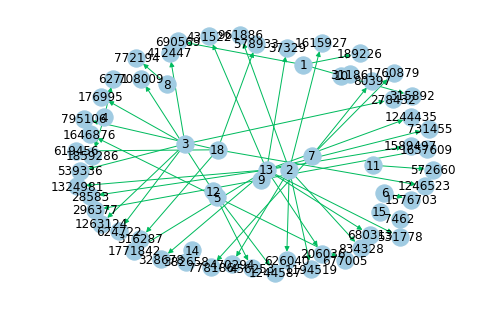

In [6]:
# create using, we can define if we want Ditrected graphg
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [7]:
# No of Unique persons 
# g is the networkx graph
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No of followers for each person

- u1 -> u2 : here u1 is following u2
- we will observe the number of followers
    - #followers = indegree
    - g.in_degree() will give the indegree for all the nodes as a dictionary
        - ie. the num of incoming nodes for all the nodes

In [8]:
# this is the list of degrees
indegree_dist = list(dict(g.in_degree()).values())

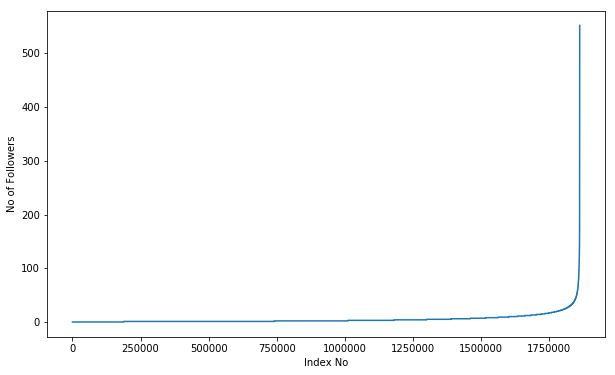

In [9]:
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of Followers')
plt.show()

- we noticed that most of the users have a very small subset of followers, but few of them have many.
    - atleast one has more than 500
    
- now we have a total of 1.86M users

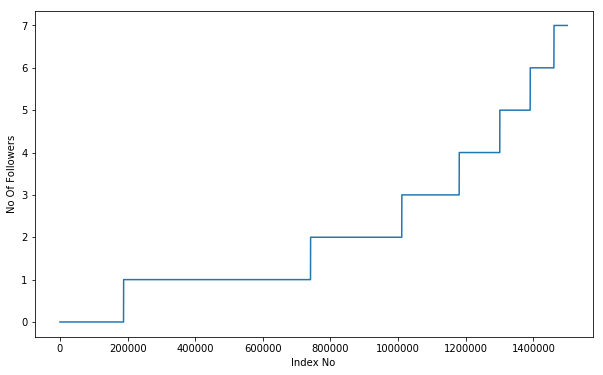

In [10]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

- almost 1.4M people as less than 7 followers
- if try to plot a box plot
    - our mean, median, 25th,50,75th percentile will be very small
    - so we will look at 90th to 100th percentile

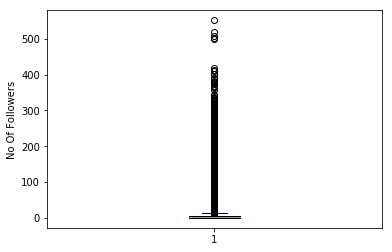

In [11]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [12]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers of 40 only.

In [13]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


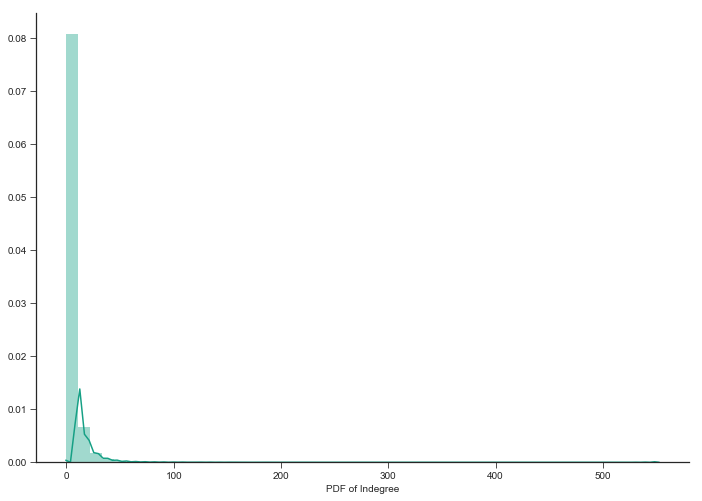

In [14]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

## 1.2 No of people each person is following

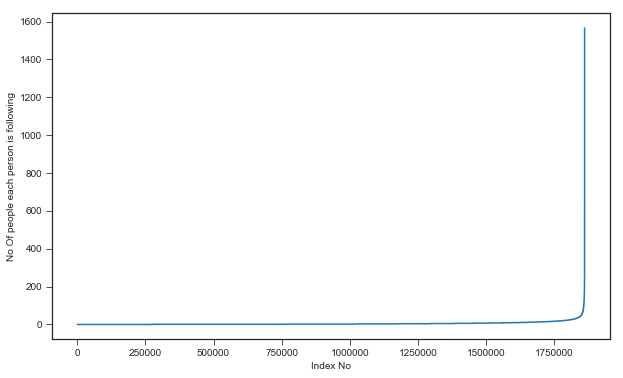

In [15]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

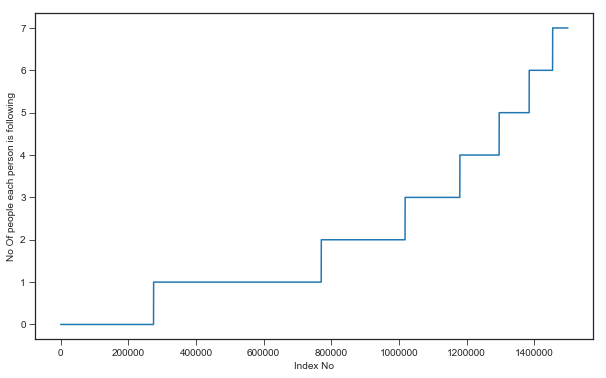

In [16]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

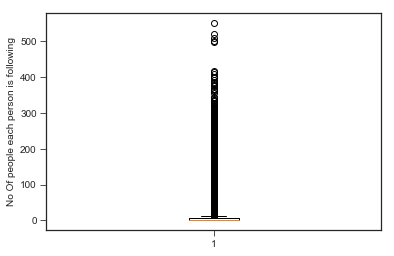

In [17]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [18]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [19]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


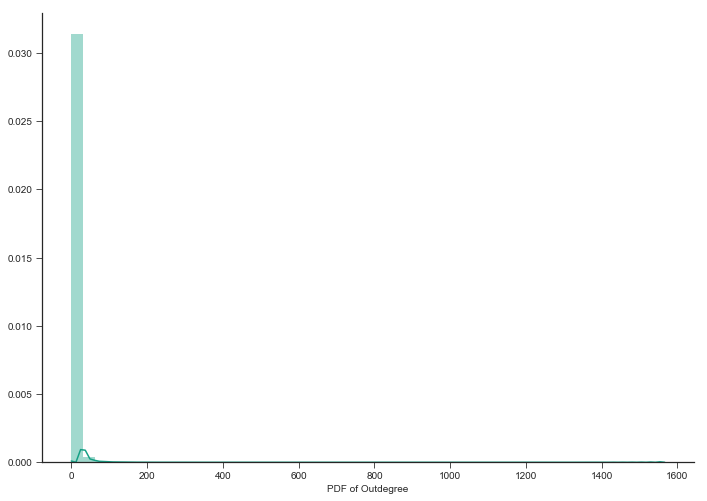

In [20]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

- degree(ui) = indegree(ui) + outdegree(ui)

In [21]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [22]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [23]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following 

In [24]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

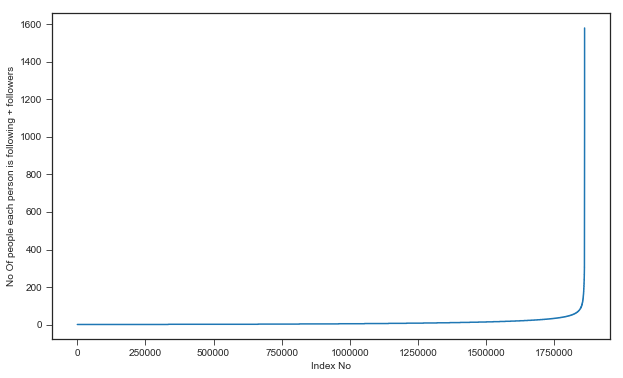

In [25]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

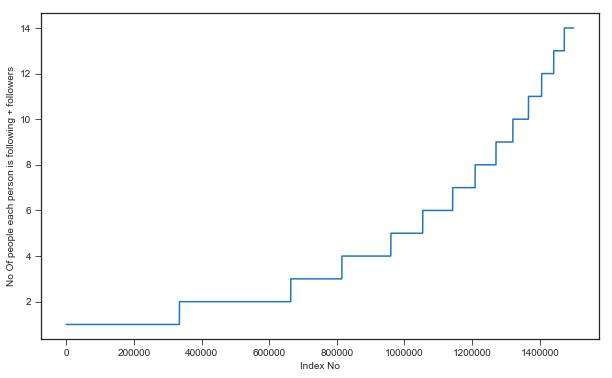

In [26]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [27]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [28]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [29]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [30]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [31]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [32]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
- Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 
- Now in our train data, we have ui,uj,1
    - 1 means there is a link
    - 0 would mean there is not a link or edge between them
    - But we dont have this 0 labeled data info in the train dataset
- Suppose there is no edge b/w u1,u2 so we can add in the dataset u1,u2,0
- Now we have 9.43M edges and 1.86M nodes
    - for each nodes, we can have n-1 directed edges
    - for n nodes, we can have n(n-1) edges
    - for 1.86M , 1.86M*(1.86M-1) edges
        - which is very large
    - But in our dataset, only small subset of edges are present
- So we will see for pair of nodes that we have an edge
    - for rest of pair of nodes which we dont have data we will call bad edges
    - bad edges we can say that edges that are not present but have a possibility
    - so we will create a random subset of 9.43M edges that are not present

- ex. u1->u2->u3->u4
    - so we can have u1,u3->0 and u1,u4->0
    - but will not consider u1,u3 as we will consider only if shortest path is more than 2
    - expln : u1 is following u2, u2 is following u3
        - there is a very high chance that u1 will eventually follow u3
    - so if len(u1,u3) <=2 will not add this to zero label dataset 
- So we are going to create same number of 0 paired data as we have for 1

In [1]:
import csv
r = csv.reader(open("data/after_eda1/train_woheader.csv",'r'))

In [2]:
edges = dict()
for edge in r:
    edges[(edge[0],edge[1])] = 1

In [5]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('data/after_eda1/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda1/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if len(missing_edges) % 1000000 == 0:
            print(len(missing_edges))
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda1/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda1/missing_edges_final.p','rb'))

Wall time: 7.74 s


In [6]:
len(missing_edges)

9437519

- now we have balanced data now
- we have 0 and 1 data
## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [8]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda1/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda1/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda1/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda1/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda1/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda1/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    #del missing_edges
    pass

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [9]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


-> now we total nodes in train data = 1.78 M
    - total nodes in test data = 1.14M
    - there are commong on 1.063 M people
-> now num of people in train but not in test 717K
    - in test but not in train : 81K
    - ie. 7% 
    - So for this 81K in test, we donot have any train data. This becomes a COLD START Problem
> we have a cold start problem here

In [16]:
#final train and test data sets
if (not os.path.isfile('data/after_eda1/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda1/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda1/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda1/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda1/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda1/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda1/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda1/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda1/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda1/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda1/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda1/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [17]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


In [53]:
# computed and store the data for featurization
# please check out FB_featurization.ipynb